# 00.Importing Libraries

In [103]:
!pip install metpy --quiet

In [104]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from metpy.calc import heat_index
from metpy.units import units

# 01.Helpers

### 01.01 Constants

In [105]:
features_datasus = ["hospitalizations", "average_stay", "deaths", "mortality_rate"]

### 01.02 Functions

In [106]:
def timelag(df, lag, features):
    for feature in features:
        df[f'{feature}_lag_{lag}'] = df[feature].shift(lag)
    return df

# 02.Importing Datasets

In [107]:
# Assigning the raw data path
urlINMET = "https://raw.githubusercontent.com/ThierrryScotto/trabalho_pratico/refs/heads/main/datasets/INMET.csv"
urlSUS = "https://raw.githubusercontent.com/ThierrryScotto/trabalho_pratico/refs/heads/main/datasets/datasus_por_local_internacao_v2.csv"

In [108]:
# Reading the INMET Dataset and deleting the removing the last column Unnamed:19
datasetINMET = pd.read_csv(urlINMET, sep=";",decimal = ',')[:-1]
datasetINMET.head(2)

,DATA,HORA,PRECIPITACAO_TOTAL_HORARIO_MM,PRESSAO_ATMOSFERICA_NIVEL_ESTACAO_HORARIA_MB,PRESSAO_ATMOSFERICA_MAX.NA_HORA_ANT_AUT_MB,PRESSAO_ATMOSFERICA_MIN_NA_HORA_ANT_AUT_MB,RADIACAO_GLOBAL_KJ_m2,TEMPERATURA_DO_AR_BULBO_SECO_HORARIA_C,TEMPERATURA_PONTO_DE_ORVALHO_C,TEMPERATURA_MAXIMA_NA_HORA_ANT_AUT_C,TEMPERATURA_MINIMA_NA_HORA_ANT_AUT_C,TEMPERATURA_ORVALHO_MAX_NA_HORA_ANT_AUT_C,TEMPERATURA_ORVALHO_MIN_NA_HORA_ANT_AUT_C,UMIDADE_REL_MAX_NA_HORA_ANT_AUT_%,UMIDADE_REL_MIN_NA_HORA_ANT_AUT_%,UMIDADE_RELATIVA_DO_AR_HORARIA_%,VENTO_DIRECAO_HORARIA_GR,VENTO_RAJADA_MAXIMA_M/S,VENTO_VELOCIDADE_HORARIA_M/S,Unnamed: 19
0,2000-09-22,22:00,0.0,1014.1,1014.3,1014.0,13.0,15.7,9.8,17.7,15.6,10.9,9.8,70.0,62.0,68.0,106.0,6.3,2.4,NaN
1,2000-09-22,21:00,0.0,1014.3,1014.3,1014.0,448.0,17.8,10.7,19.8,17.8,10.7,9.4,63.0,51.0,63.0,112.0,4.7,2.2,NaN


# 03.DATASUS pre-processing

In [109]:
# Reading the DATASUS Dataset an renaming columns
datasetDATASUS= pd.read_csv(urlSUS, sep=";",decimal = ',')

datasetDATASUS.rename(columns={
    'Ano/mes processamento': 'date',
    'Internacoes': 'hospitalizations',
    'Media_Permanencia': "average_stay",
    'Obitos': 'deaths',
    'Taxa_Mortalidade': 'mortality_rate'
    }, inplace=True)

datasetDATASUS.head(2)

,date,hospitalizations,average_stay,deaths,mortality_rate
0,..Janeiro/1998,3905,6.3,229,5.86
1,..Fevereiro/1998,3502,5.8,200,5.71


## 03.01 Adjusting the date column

In [110]:
## Ajusting date column format
datasetDATASUS['date'] = datasetDATASUS['date'].str.lstrip('.')

months = {
    'Janeiro': '01', 'Fevereiro': '02', 'Marco': '03', 'Abril': '04',
    'Maio': '05', 'Junho': '06', 'Julho': '07', 'Agosto': '08',
    'Setembro': '09', 'Outubro': '10', 'Novembro': '11', 'Dezembro': '12'
}

datasetDATASUS['date'] = datasetDATASUS['date'].replace(months, regex=True).apply(lambda x: x.strip())
datasetDATASUS['date'] = pd.to_datetime(datasetDATASUS['date'], format='%m/%Y')

datasetDATASUS.head(2)

,date,hospitalizations,average_stay,deaths,mortality_rate
0,1998-01-01,3905,6.3,229,5.86
1,1998-02-01,3502,5.8,200,5.71


In [111]:
# Verifying missing dates

start_date = datasetDATASUS["date"].min()
end_date = datasetDATASUS["date"].max()
expected_dates = pd.date_range(start=start_date, end=end_date, freq="MS")

missing_dates = expected_dates.difference(datasetDATASUS["date"])

if missing_dates.empty:
    print("No missing dates")
else:
    print("Missing dates:")
    print(missing_dates)

No missing dates


## 03.02 Raw Dataset Summary

In [112]:
# Generating summary of the dataset including shape, number of non-null values in each column, data types and memory usage
print('-----------------------------------')
print('Sahpe of de dataset:')
print(datasetDATASUS.shape)
print('-----------------------------------')

datasetDATASUS.info()

-----------------------------------
Sahpe of de dataset:
(321, 5)
-----------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 321 entries, 0 to 320
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   date              321 non-null    datetime64[ns]
 1   hospitalizations  321 non-null    int64         
 2   average_stay      321 non-null    float64       
 3   deaths            321 non-null    int64         
 4   mortality_rate    321 non-null    float64       
dtypes: datetime64[ns](1), float64(2), int64(2)
memory usage: 12.7 KB


In [113]:
# Generating summary statistics for numerical columns in the dataset
datasetINMET.describe()

,PRECIPITACAO_TOTAL_HORARIO_MM,PRESSAO_ATMOSFERICA_NIVEL_ESTACAO_HORARIA_MB,PRESSAO_ATMOSFERICA_MAX.NA_HORA_ANT_AUT_MB,PRESSAO_ATMOSFERICA_MIN_NA_HORA_ANT_AUT_MB,RADIACAO_GLOBAL_KJ_m2,TEMPERATURA_DO_AR_BULBO_SECO_HORARIA_C,TEMPERATURA_PONTO_DE_ORVALHO_C,TEMPERATURA_MAXIMA_NA_HORA_ANT_AUT_C,TEMPERATURA_MINIMA_NA_HORA_ANT_AUT_C,TEMPERATURA_ORVALHO_MAX_NA_HORA_ANT_AUT_C,TEMPERATURA_ORVALHO_MIN_NA_HORA_ANT_AUT_C,VENTO_RAJADA_MAXIMA_M/S,VENTO_VELOCIDADE_HORARIA_M/S,Unnamed: 19
count,211101.000000,211100.000000,211087.000000,211087.000000,187429.000000,211100.000000,211095.000000,211087.000000,211087.000000,211087.000000,211086.000000,211024.000000,211049.000000,0.0
mean,-311.501318,667.961157,649.641440,649.101180,-3419.157770,-286.630909,-291.612510,-305.700307,-306.585464,-310.526326,-311.397870,-368.437672,-350.816791,NaN
std,1737.627816,1909.569309,1959.137815,1959.038621,5580.226428,1725.637233,1725.733811,1778.167579,1777.736922,1777.679744,1777.524334,1895.892561,1843.798993,NaN
min,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,NaN
25%,0.000000,1005.500000,1005.800000,1005.200000,-9999.000000,15.600000,11.900000,16.000000,15.200000,12.300000,11.400000,2.500000,0.700000,NaN
50%,0.000000,1009.300000,1009.500000,1009.000000,70.900000,19.800000,15.500000,20.300000,19.400000,16.000000,15.100000,4.300000,1.300000,NaN
75%,0.000000,1013.300000,1013.600000,1013.100000,1249.100000,23.600000,18.600000,24.200000,23.100000,19.000000,18.200000,6.300000,2.100000,NaN
max,47.600000,1032.000000,1032.000000,1031.500000,3999.900000,40.200000,27.100000,40.600000,39.400000,27.500000,25.900000,33.200000,13.300000,NaN


In [114]:
# Verifying the number of non-null values
datasetDATASUS.isna().sum()

,0
date,0
hospitalizations,0
average_stay,0
deaths,0
mortality_rate,0


## 03.03 Handling invalid values

In [115]:
# Checking for negative values

for column in datasetDATASUS.columns[1:]:
    print(datasetDATASUS[datasetDATASUS[column] < 0], "\n")

Empty DataFrame
Columns: [date, hospitalizations, average_stay, deaths, mortality_rate]
Index: [] 

Empty DataFrame
Columns: [date, hospitalizations, average_stay, deaths, mortality_rate]
Index: [] 

Empty DataFrame
Columns: [date, hospitalizations, average_stay, deaths, mortality_rate]
Index: [] 

Empty DataFrame
Columns: [date, hospitalizations, average_stay, deaths, mortality_rate]
Index: [] 



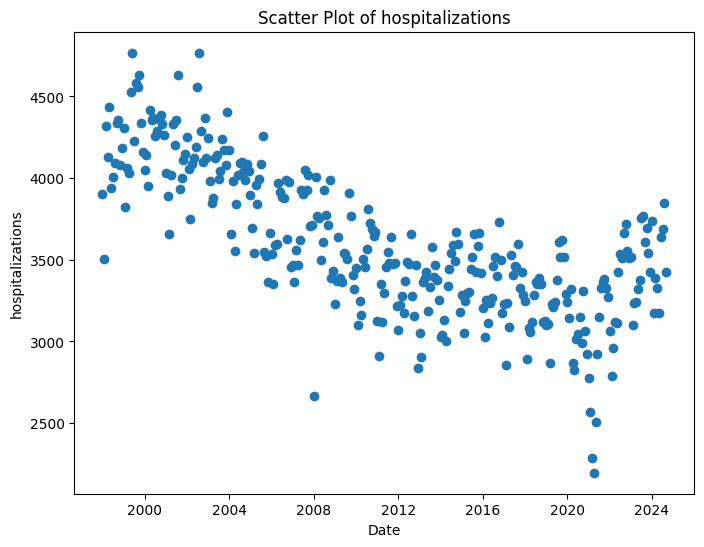

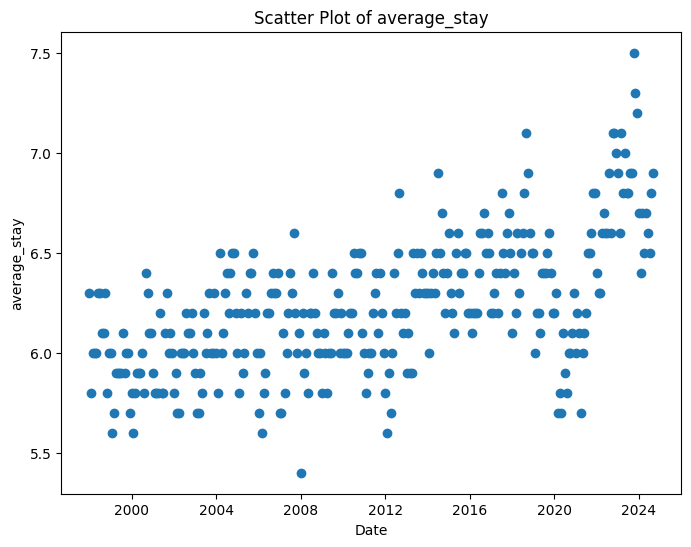

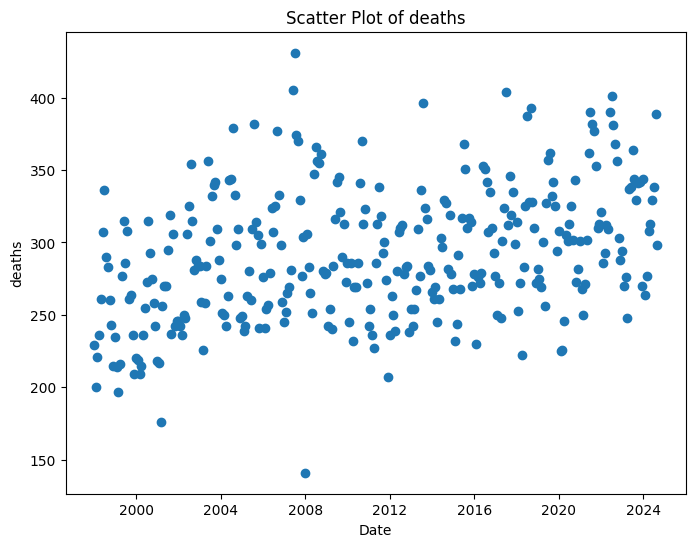

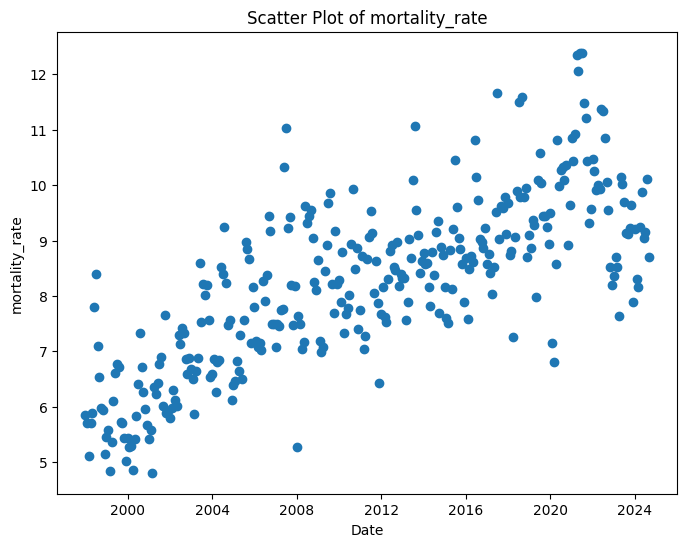

In [116]:
# Checking for unreasonable values

for column in datasetDATASUS.columns[1:]:
    plt.figure(figsize=(8, 6))
    plt.scatter(datasetDATASUS['date'],datasetDATASUS[column])
    plt.title(f'Scatter Plot of {column}')
    plt.xlabel('Date')
    plt.ylabel(column)
    plt.show()


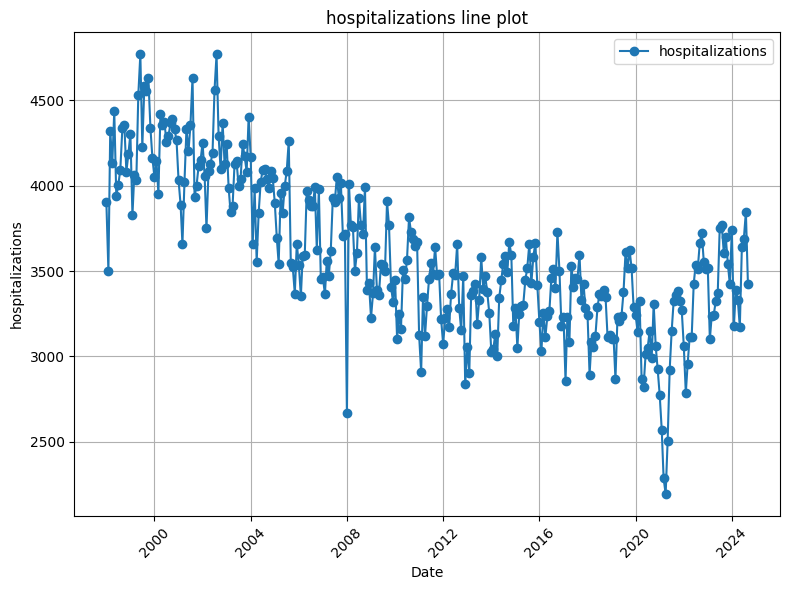

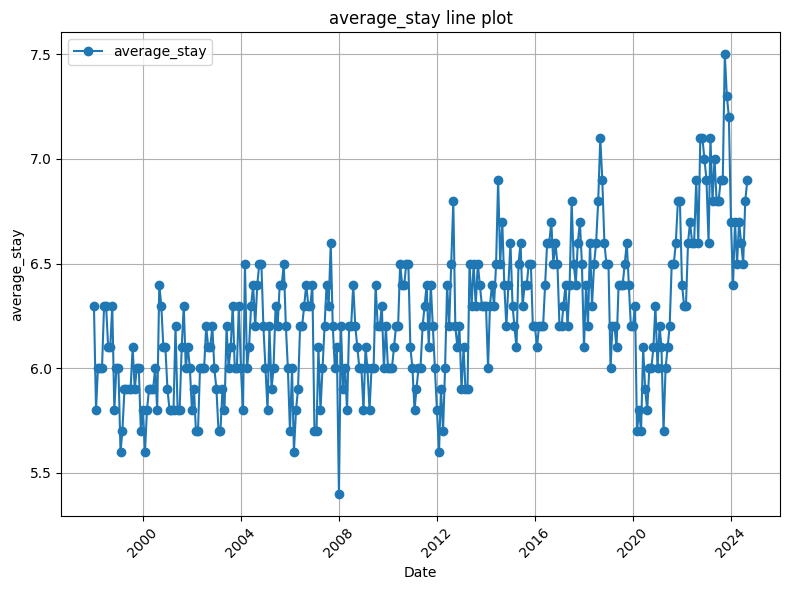

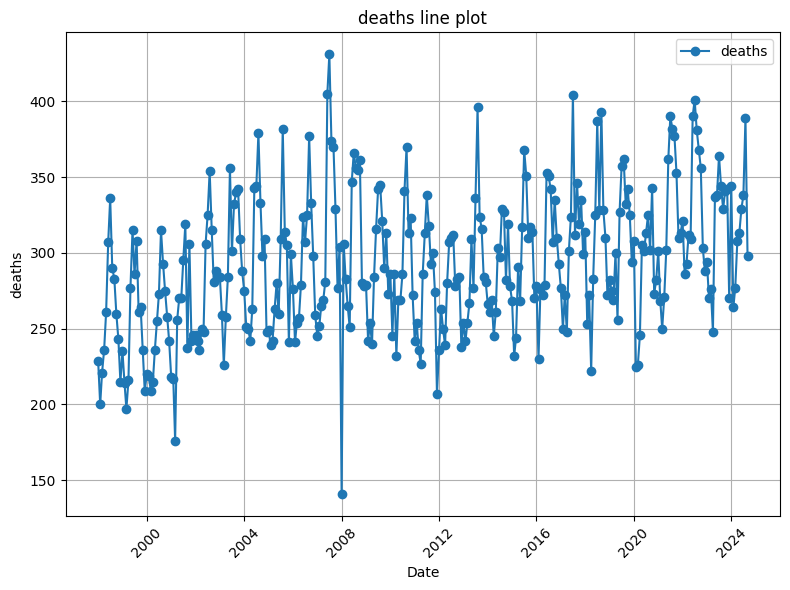

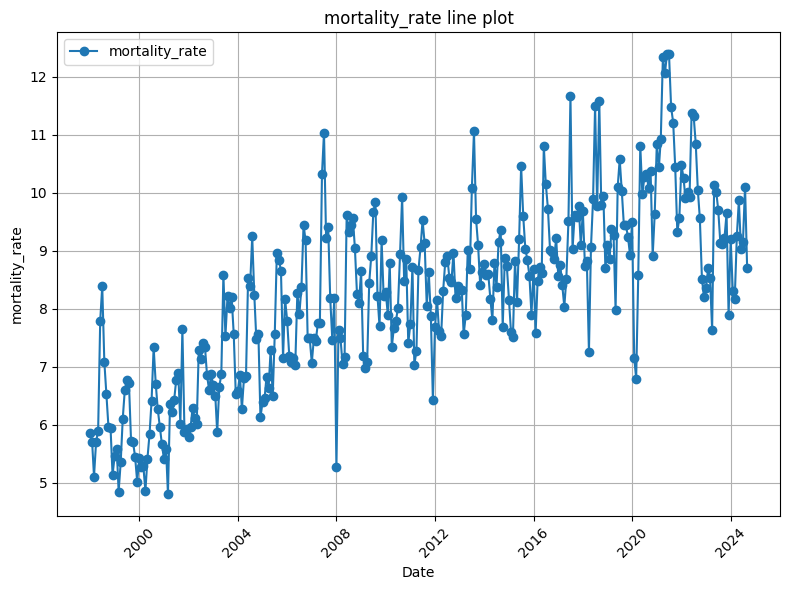

In [117]:
# Checking for unreasonable values

for column in datasetDATASUS.columns[1:]:
    plt.figure(figsize=(8, 6))
    plt.plot(datasetDATASUS['date'],datasetDATASUS[column], marker='o', label=column)
    plt.title(f'{column} line plot')
    plt.xlabel('Date')
    plt.ylabel(column)
    plt.grid(True)
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


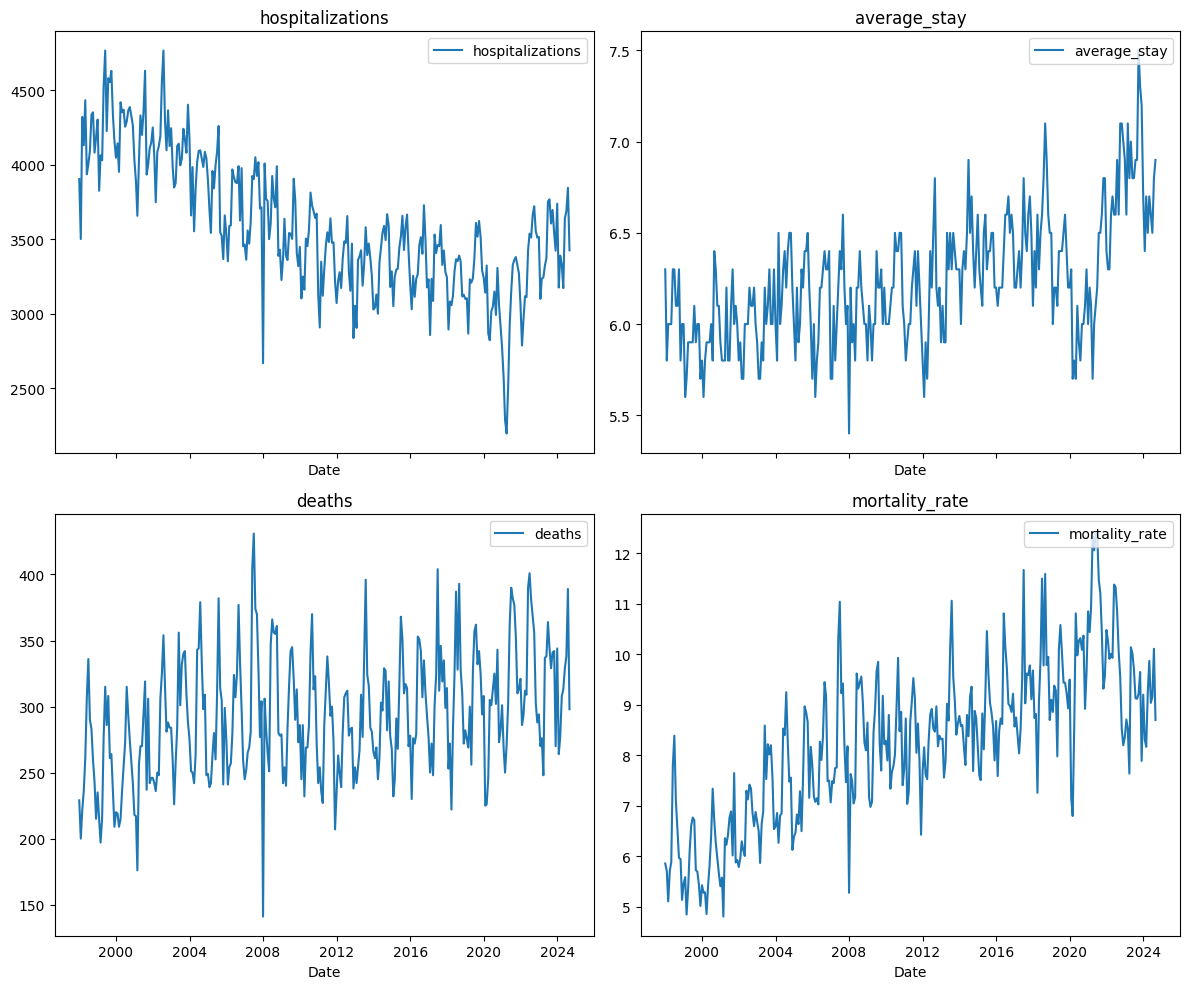

In [118]:
# Creating subplots in a 2x2 matrix
fig, axes = plt.subplots(2, 2, figsize=(12, 10), sharex=True)
axes = axes.flatten()

for index, column in enumerate(datasetDATASUS.columns[1:]):
    axes[index].plot(datasetDATASUS['date'],datasetDATASUS[column], label=column)
    axes[index].set_title(f"{column}")
    axes[index].legend(loc="upper right")
    axes[index].set_xlabel("Date")

plt.xlabel("Date")
plt.tight_layout()
plt.savefig('plotDATASUS.png', dpi=300)
plt.show()

In [119]:
# Outliers in number of deaths
datasetDATASUS[(datasetDATASUS['deaths'] >  400) |  (datasetDATASUS['deaths'] < 150)]

,date,hospitalizations,average_stay,deaths,mortality_rate
113,2007-06-01,3925,6.2,405,10.32
114,2007-07-01,3904,6.4,431,11.04
120,2008-01-01,2668,5.4,141,5.28
234,2017-07-01,3461,6.8,404,11.67
294,2022-07-01,3538,6.6,401,11.33


## 03.04 Feature engineering

In [154]:
# Generating the timelags to include other cardiovascular features in the model

datasetDATASUS_with_lags = datasetDATASUS.copy()
columns = datasetDATASUS.columns[1:]
lags = [3, 6, 12]

for lag in lags:
    for column in columns:
        datasetDATASUS_with_lags[f'{column}_lag_{lag}'] = datasetDATASUS[column].shift(lag)

datasetDATASUS_with_lags = datasetDATASUS_with_lags.dropna()

# transforming deaths and hospitalization columns in integers

for column in datasetDATASUS_with_lags.columns:
    if ('deaths' in column) | ('hospitalization' in column):
        datasetDATASUS_with_lags[column] = datasetDATASUS_with_lags[column].astype(int)
        print(f'{column} column type changed to int')

hospitalizations column type changed to int
deaths column type changed to int
hospitalizations_lag_3 column type changed to int
deaths_lag_3 column type changed to int
hospitalizations_lag_6 column type changed to int
deaths_lag_6 column type changed to int
hospitalizations_lag_12 column type changed to int
deaths_lag_12 column type changed to int


In [155]:
# Transforming date column to the same format as INMET
datasetDATASUS_with_lags['date'] = datasetDATASUS_with_lags['date'].dt.strftime('%Y-%m')

## 03.05 Saving the Dataset

In [161]:
#removing present values of average_stay, death and mortality_rate
datasetDATASUS_with_lags = datasetDATASUS_with_lags.drop(['average_stay', 'deaths', 'mortality_rate'], axis=1)

datasetDATASUS_with_lags.to_csv('datasetDATASUS.csv', index=False)

In [162]:
# Generating summary of the dataset including shape, number of non-null values in each column, data types and memory usage
print('-----------------------------------')
print('Sahpe of de dataset:')
print(datasetDATASUS_with_lags.shape)
print('-----------------------------------')

datasetDATASUS_with_lags.info()

-----------------------------------
Sahpe of de dataset:
(309, 14)
-----------------------------------
<class 'pandas.core.frame.DataFrame'>
Index: 309 entries, 12 to 320
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   date                     309 non-null    object 
 1   hospitalizations         309 non-null    int64  
 2   hospitalizations_lag_3   309 non-null    int64  
 3   average_stay_lag_3       309 non-null    float64
 4   deaths_lag_3             309 non-null    int64  
 5   mortality_rate_lag_3     309 non-null    float64
 6   hospitalizations_lag_6   309 non-null    int64  
 7   average_stay_lag_6       309 non-null    float64
 8   deaths_lag_6             309 non-null    int64  
 9   mortality_rate_lag_6     309 non-null    float64
 10  hospitalizations_lag_12  309 non-null    int64  
 11  average_stay_lag_12      309 non-null    float64
 12  deaths_lag_12            309 non-nu

## 03.06 Final plot

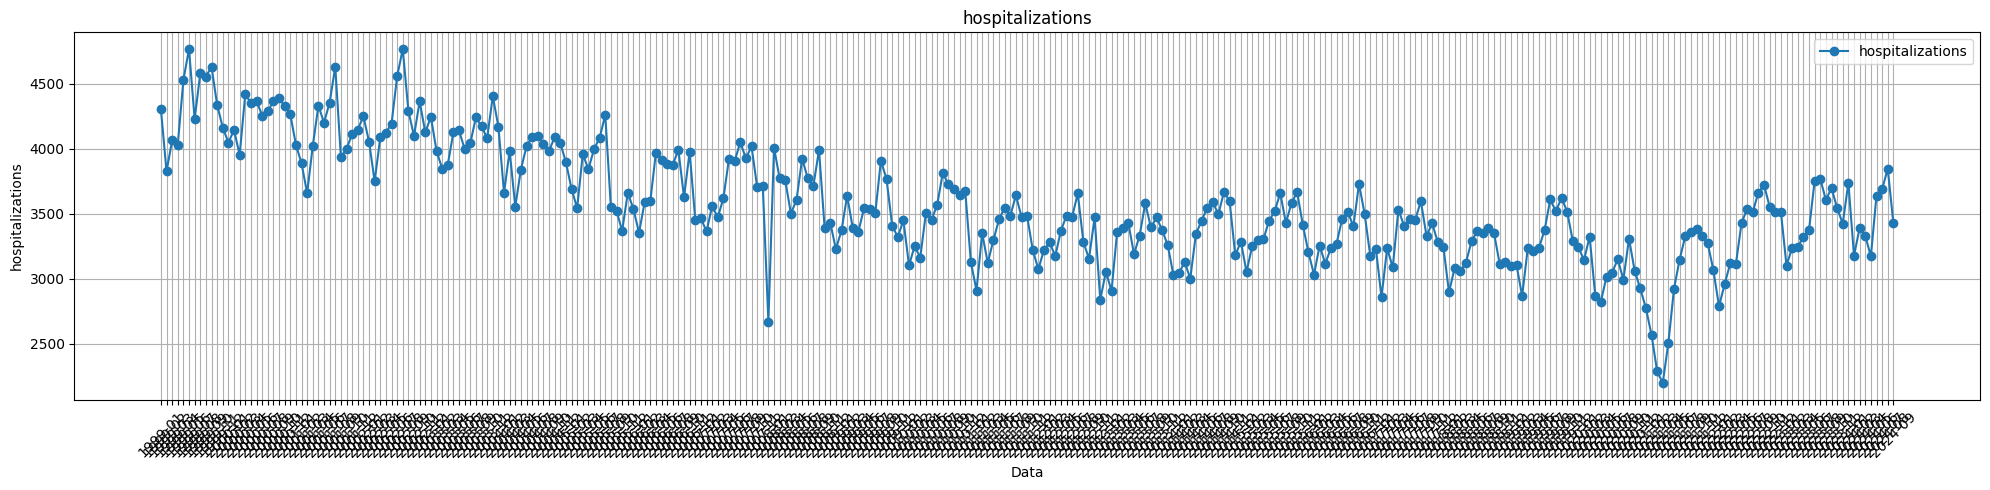

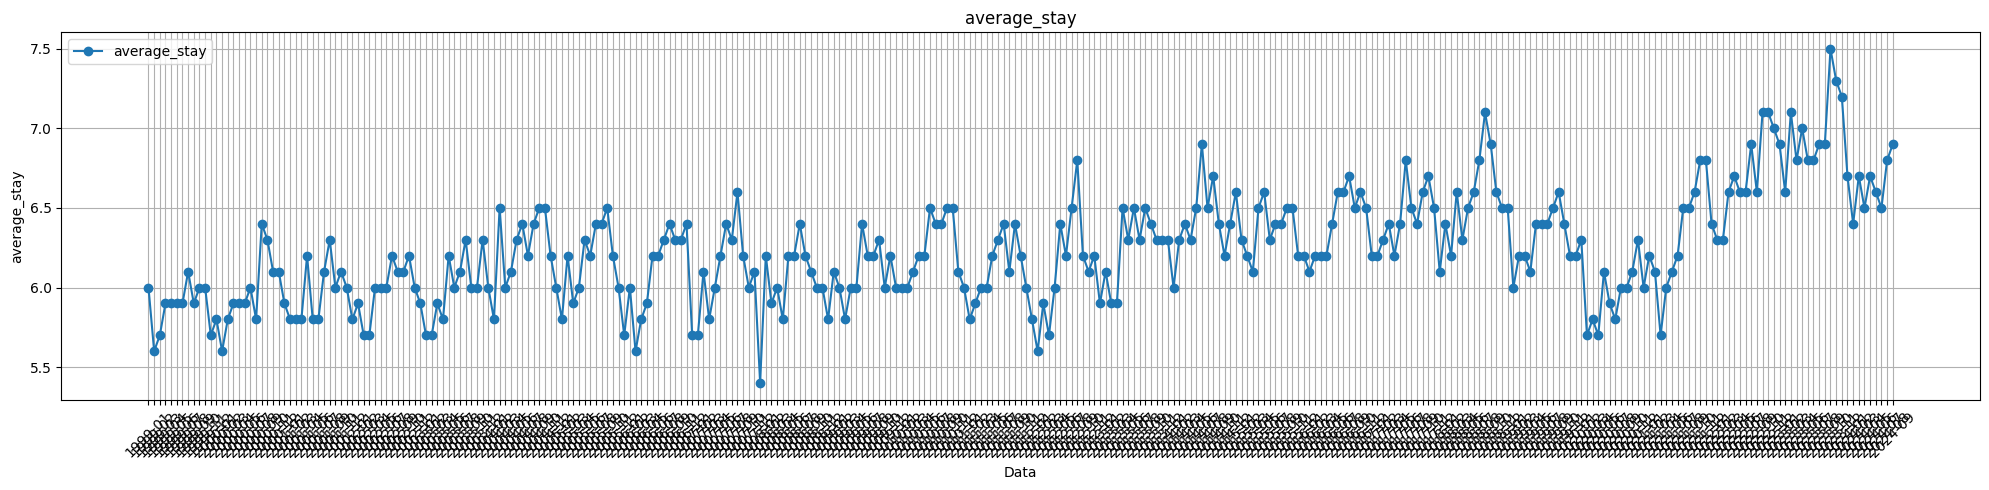

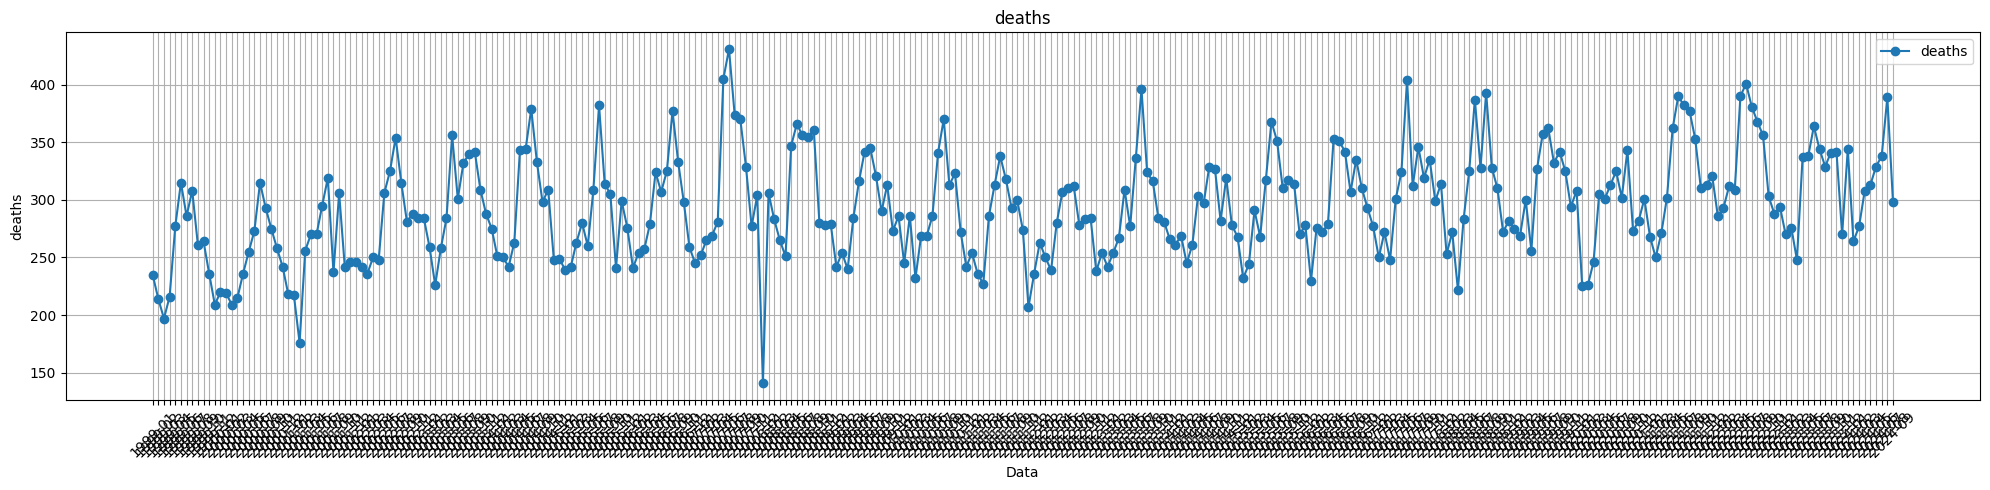

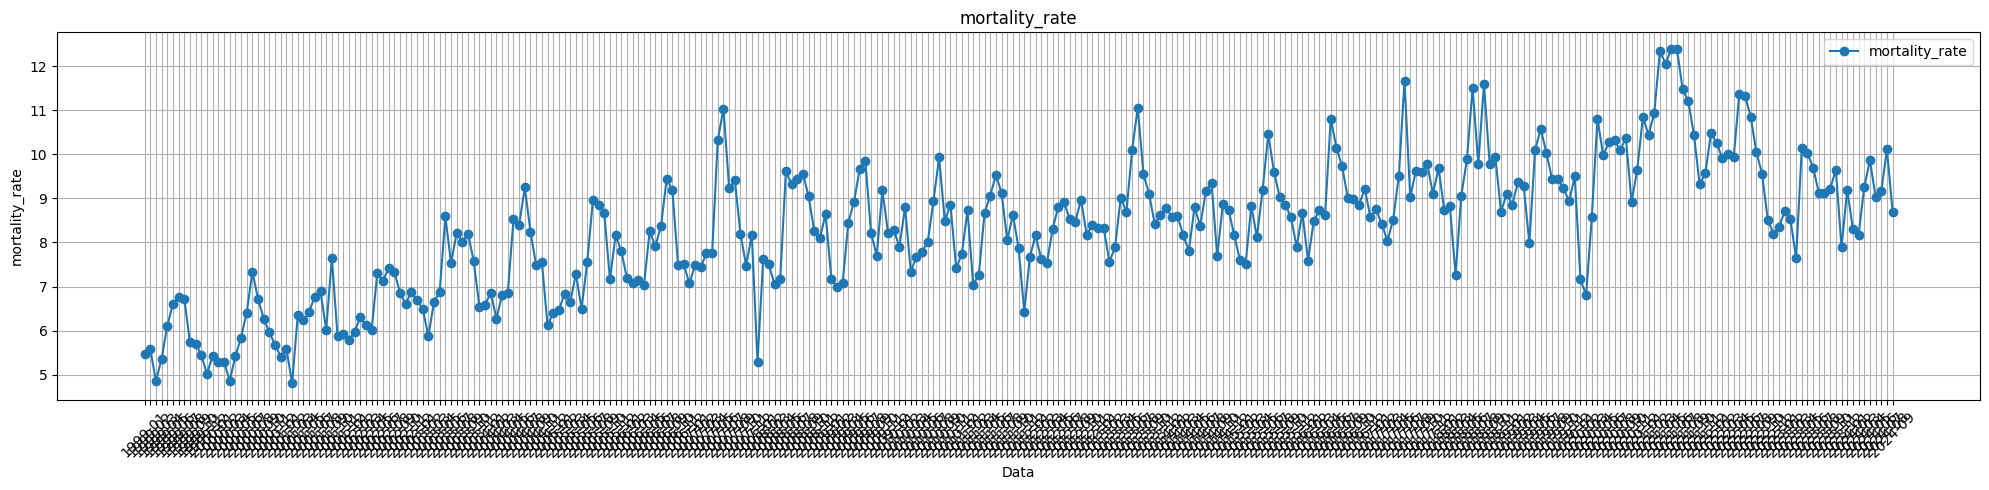

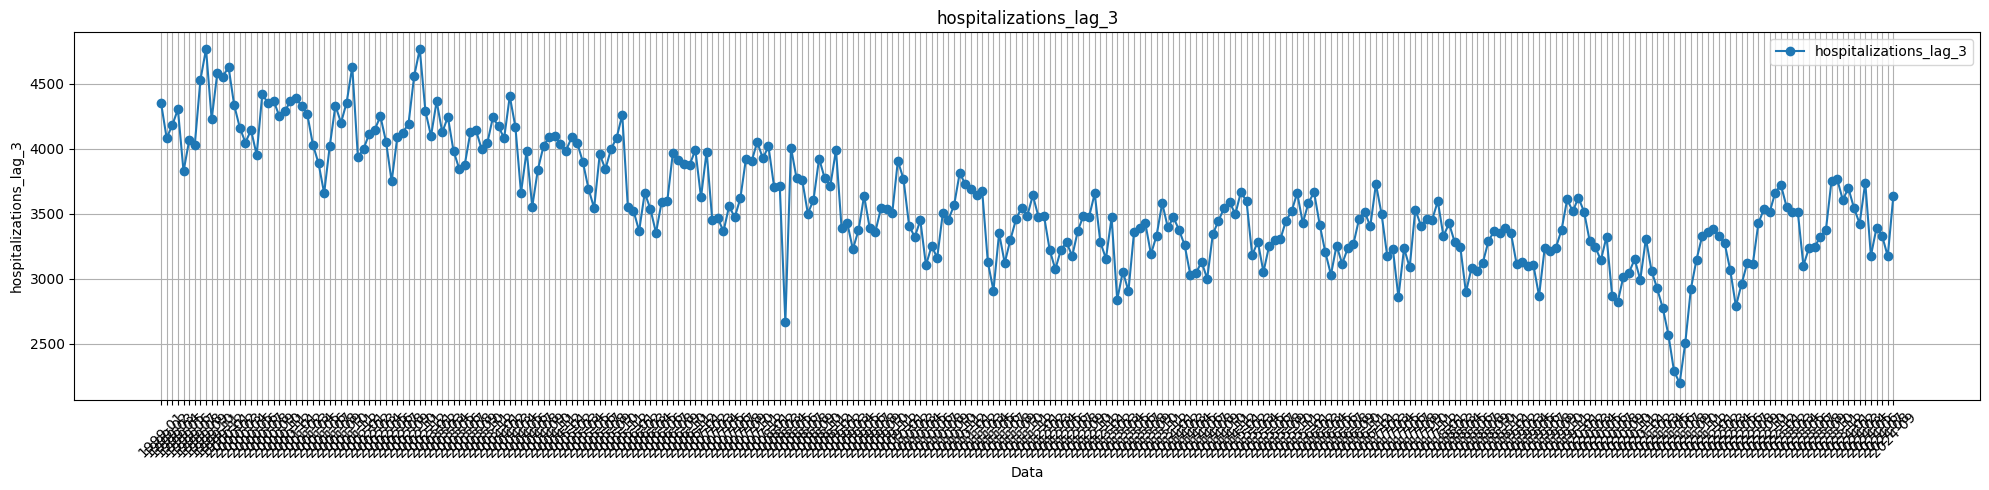

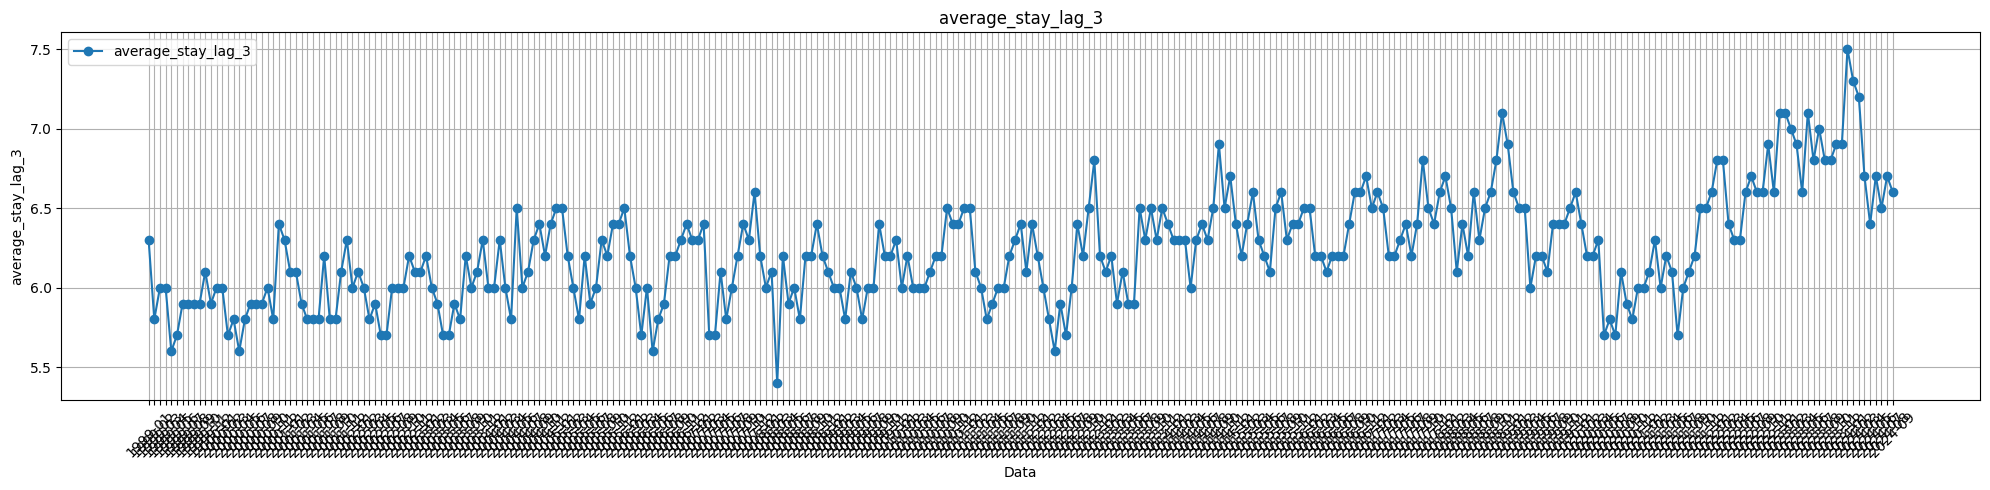

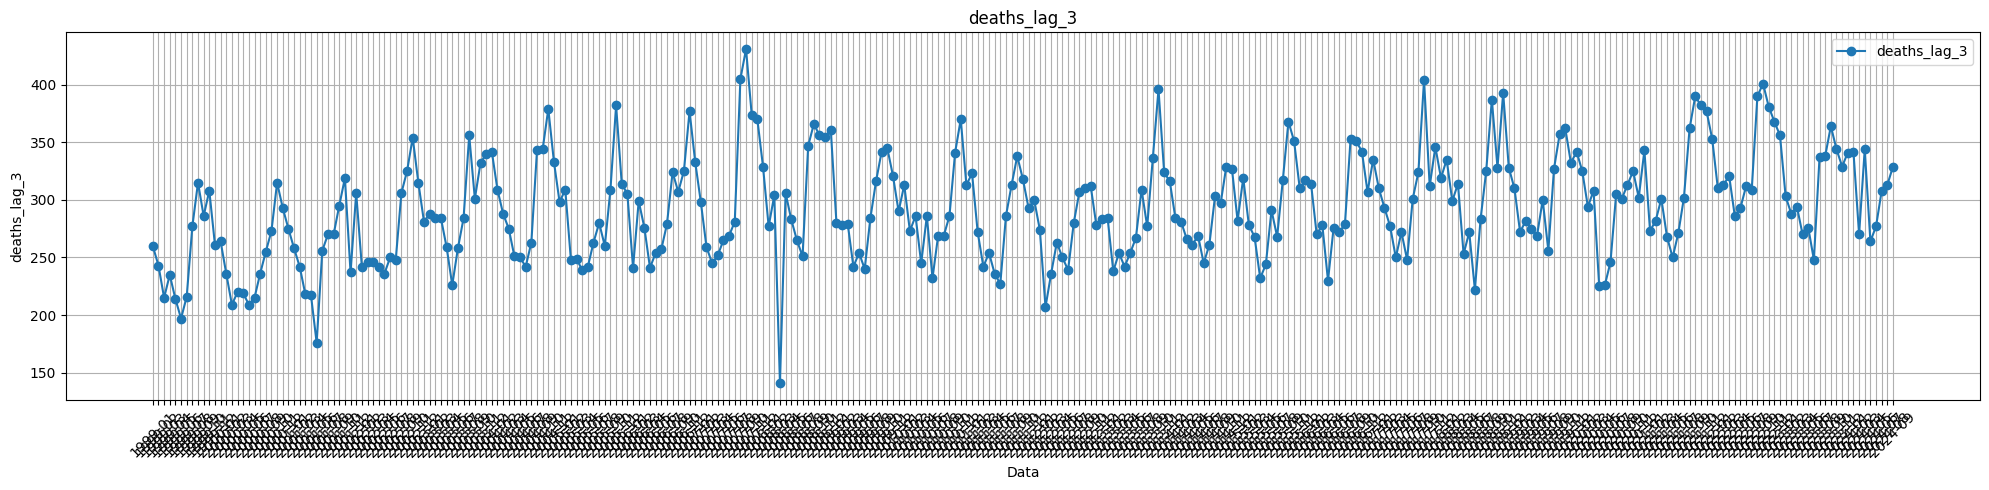

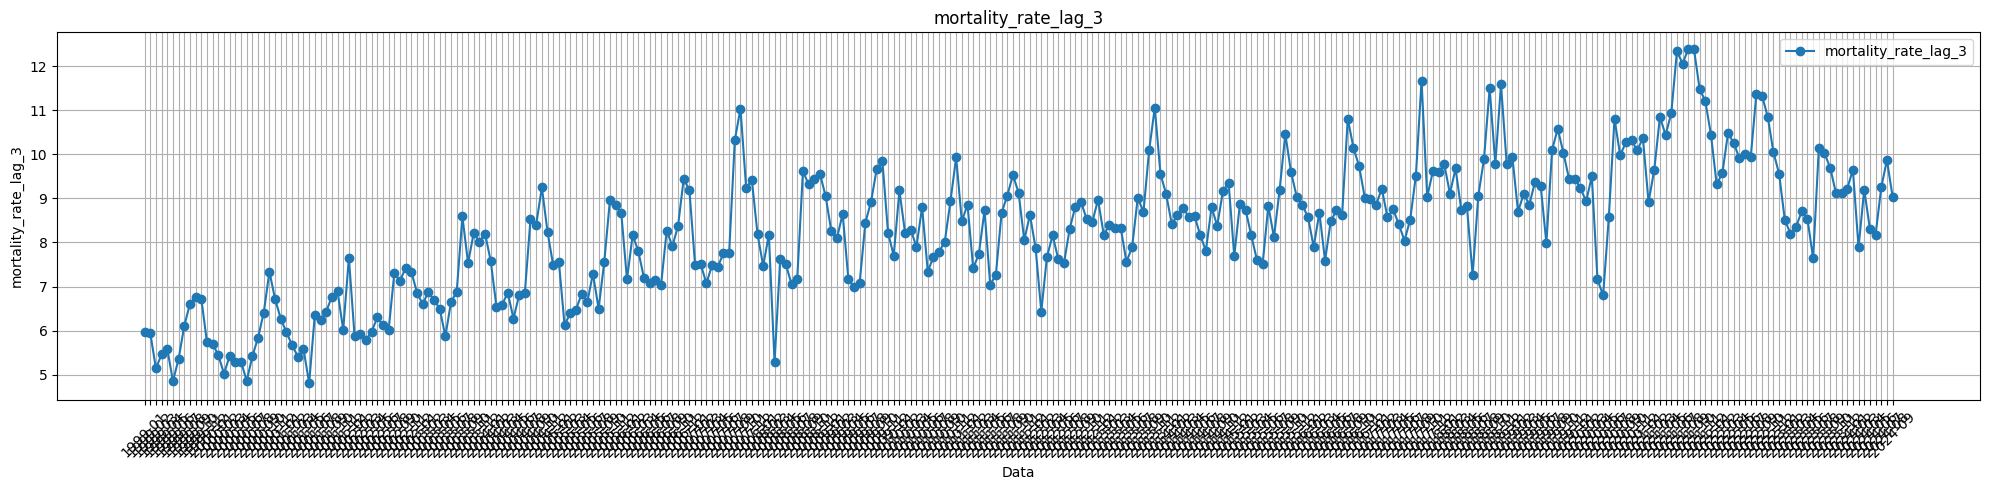

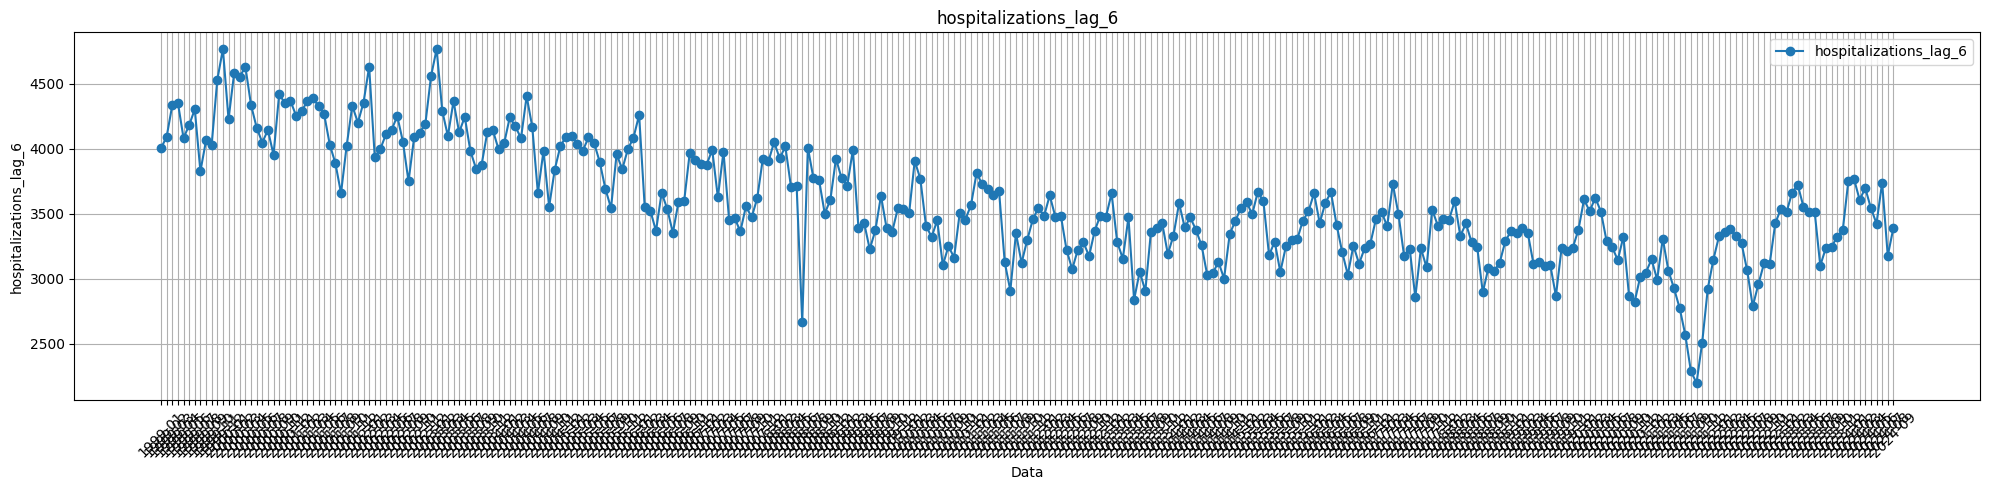

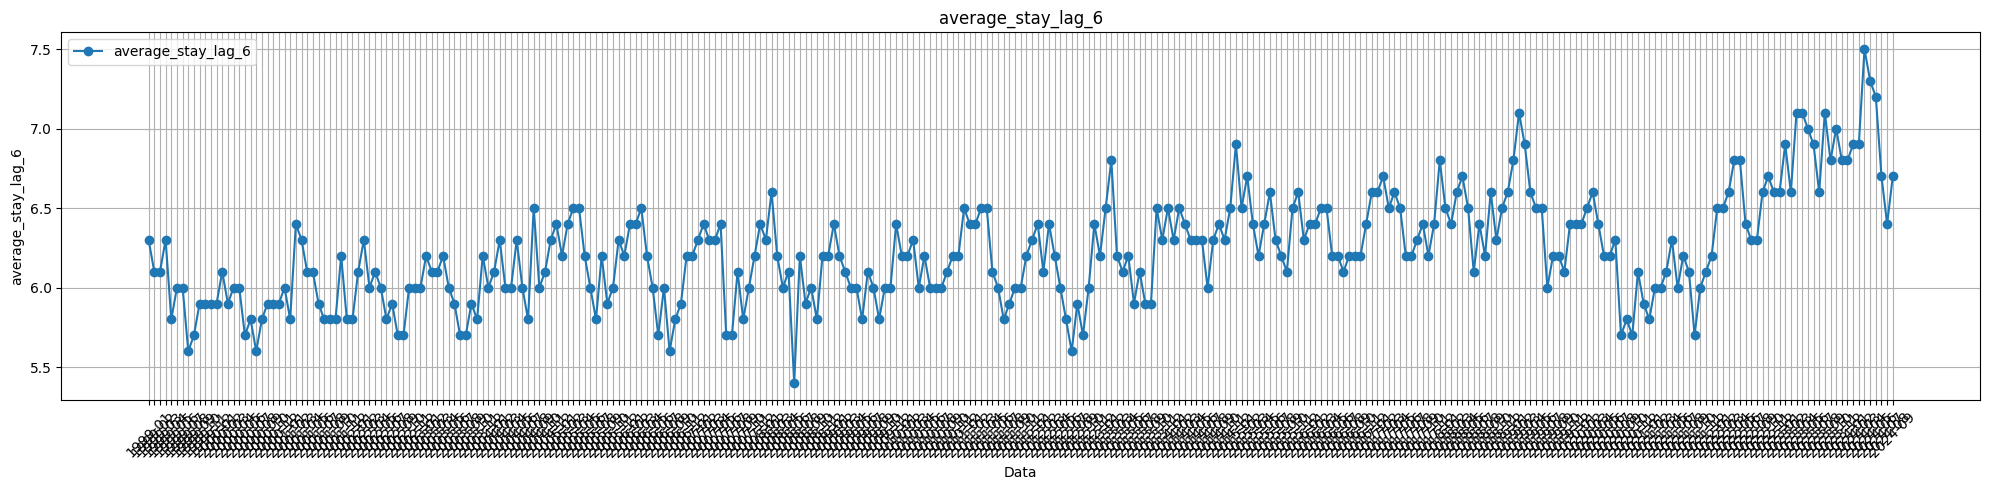

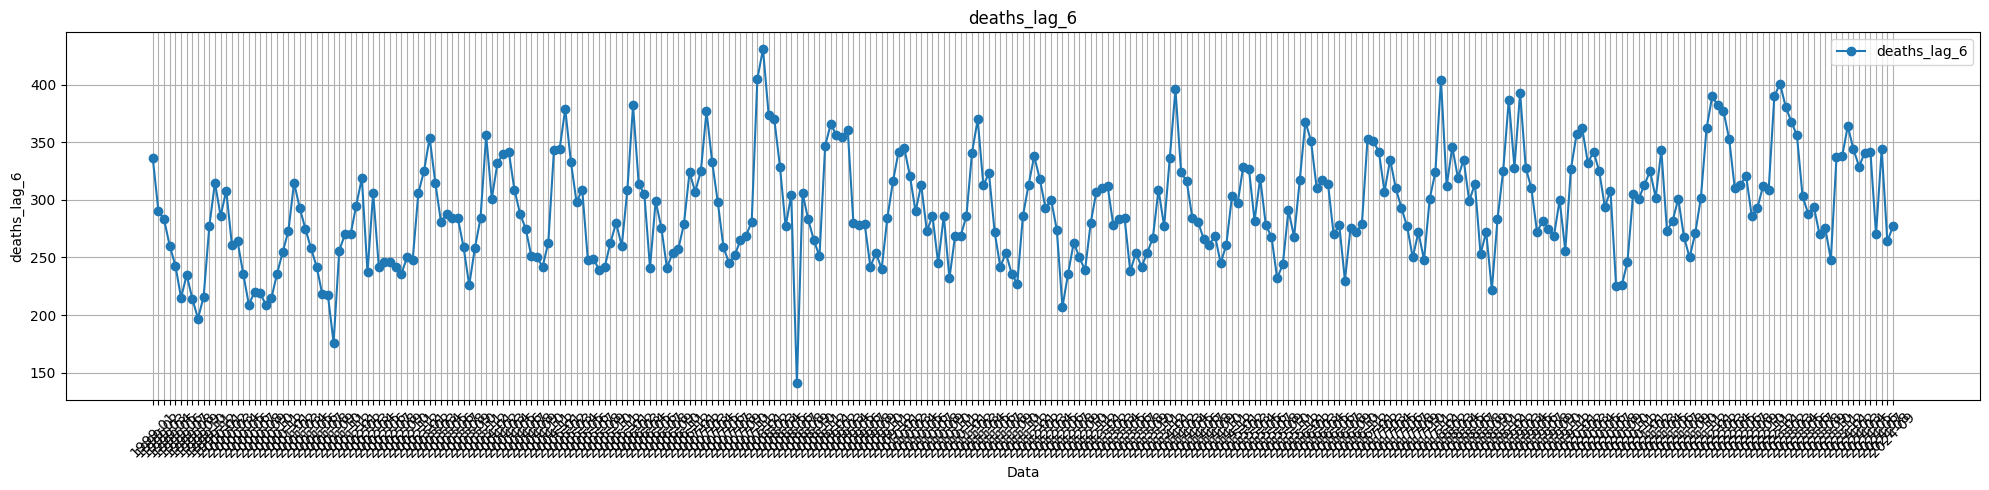

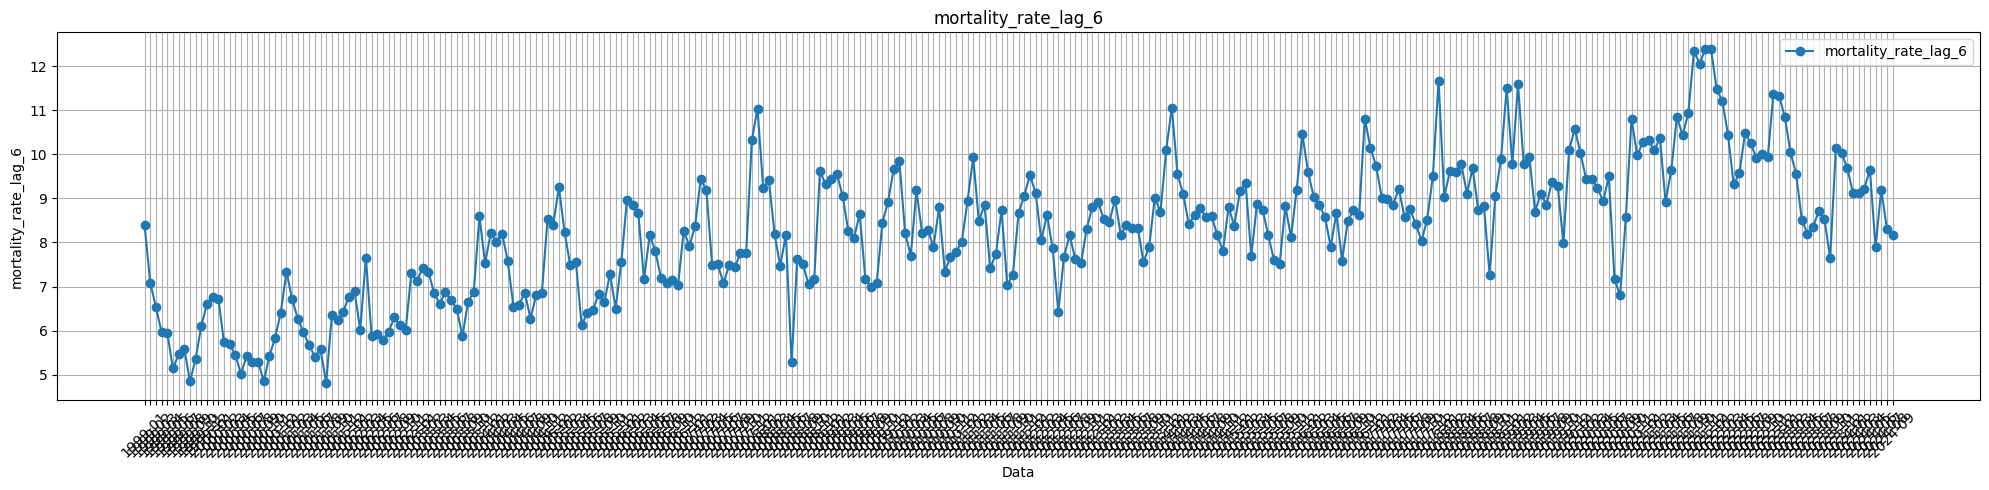

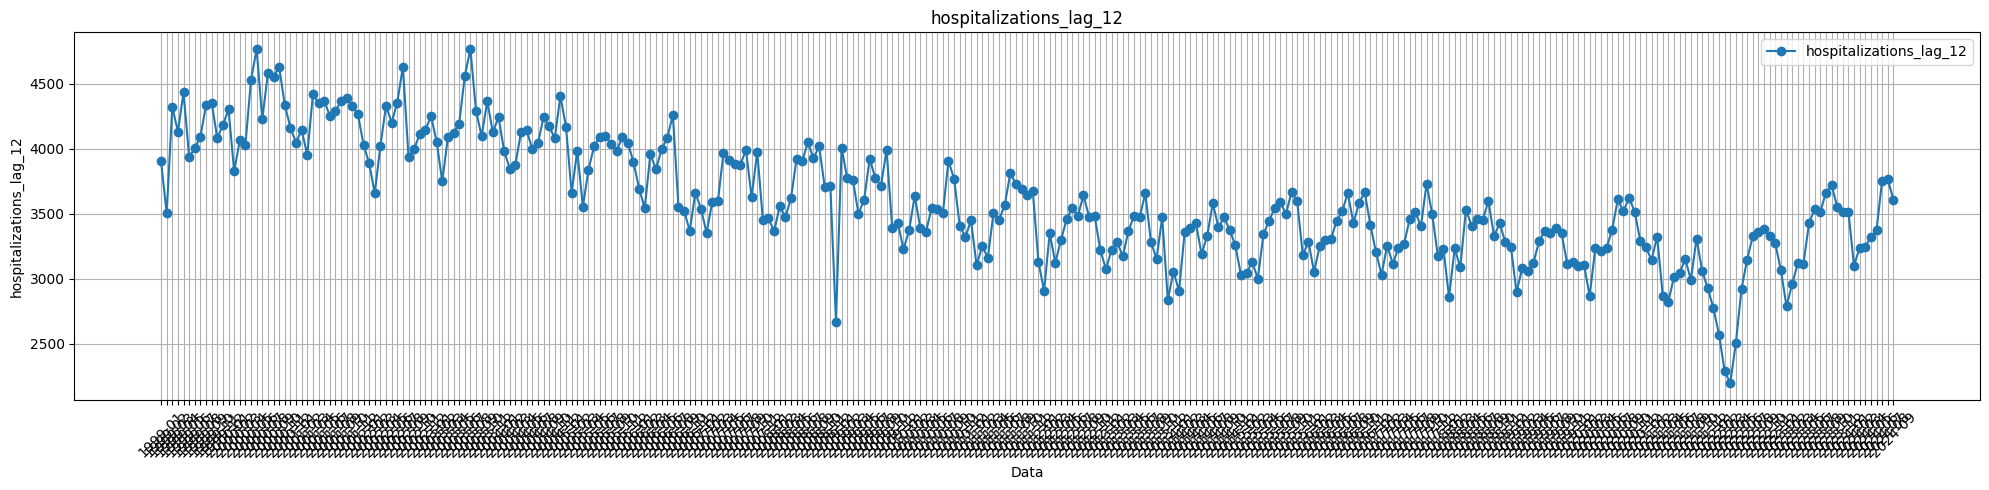

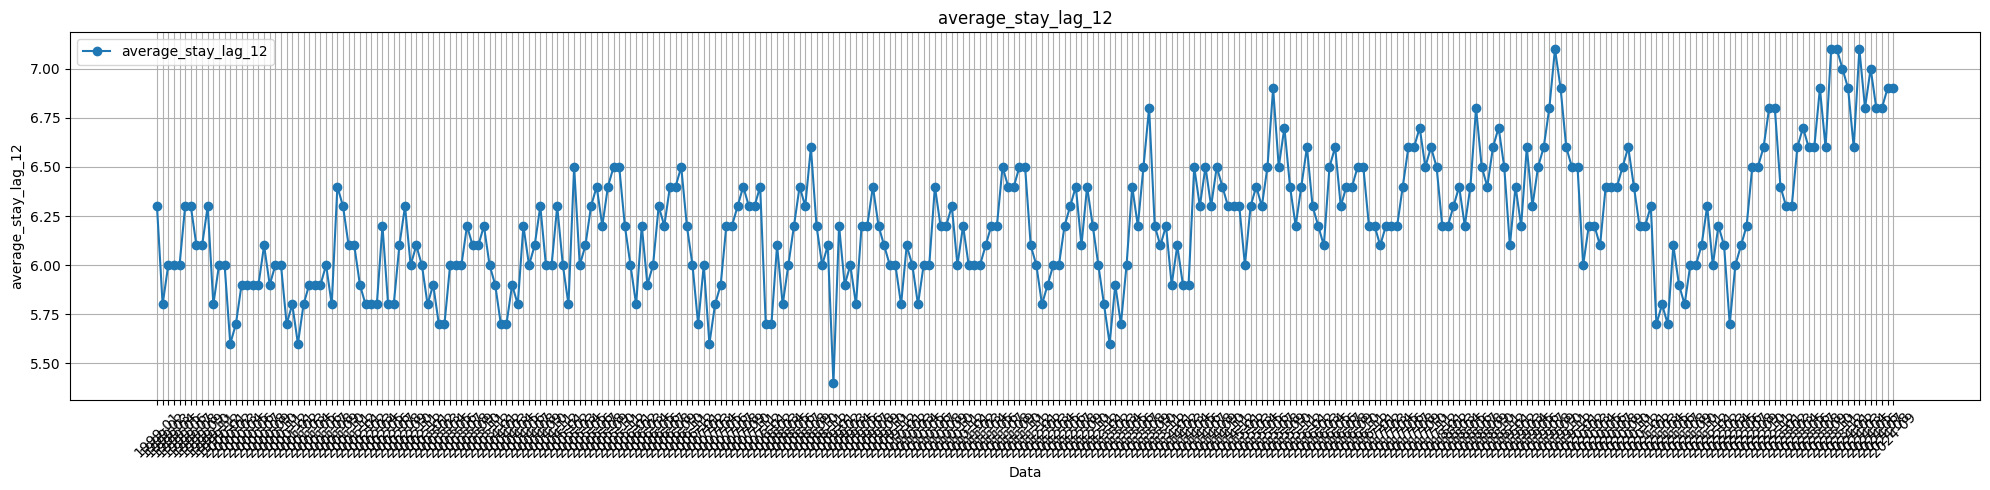

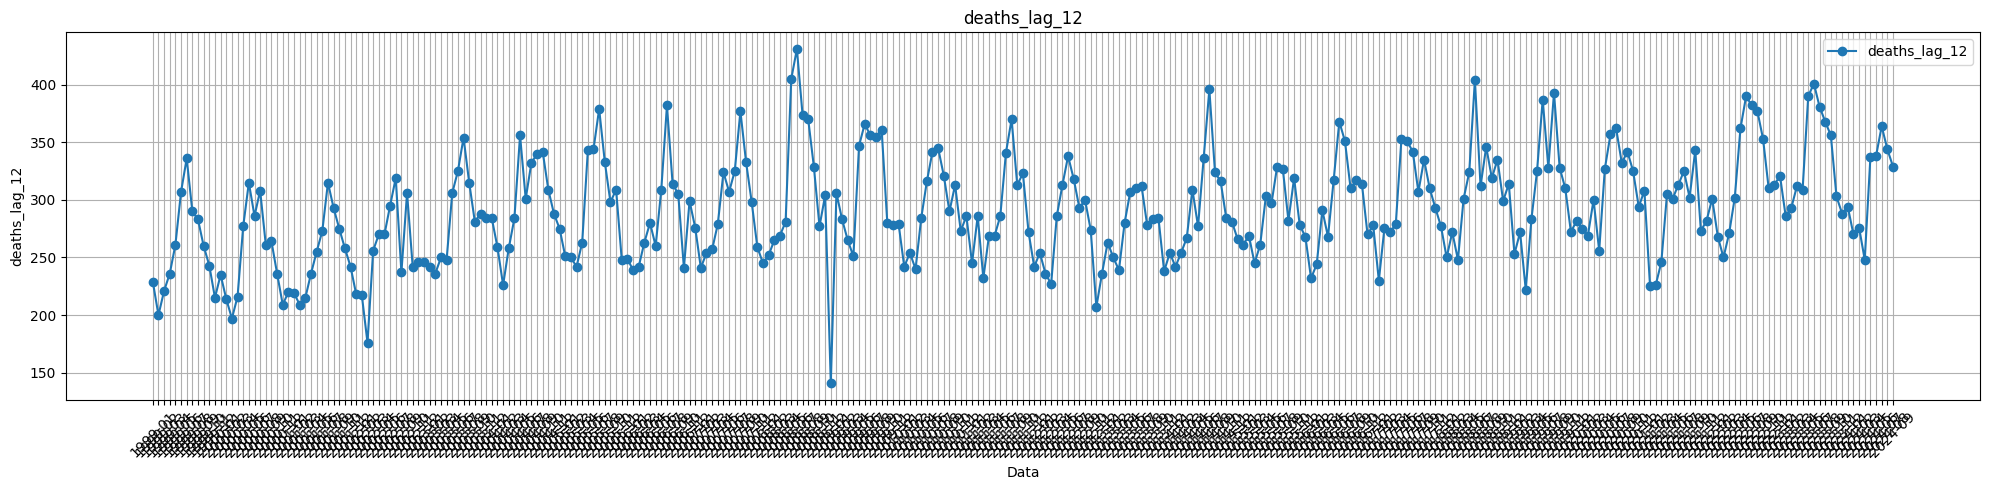

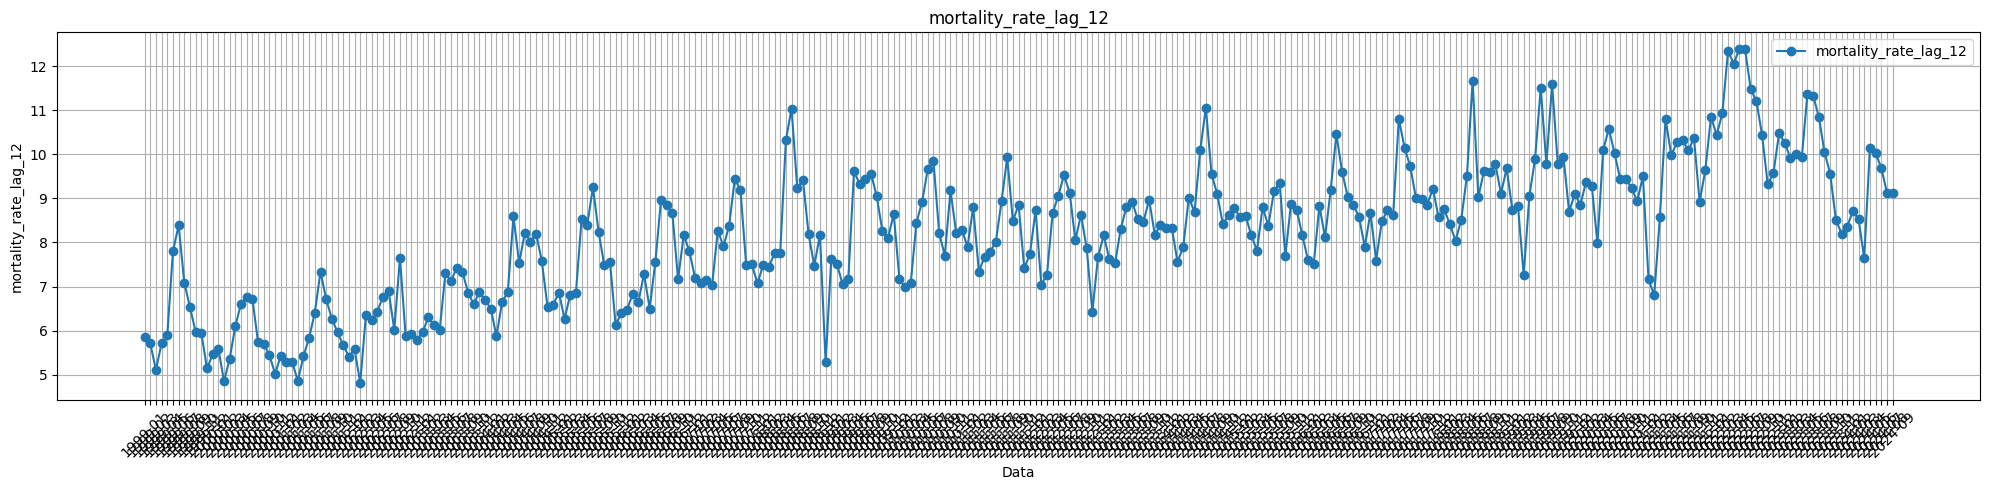

In [160]:
for variable in datasetDATASUS_with_lags.columns[1:]:
    plt.figure(figsize=(20, 5))
    plt.plot(datasetDATASUS_with_lags['date'].values, datasetDATASUS_with_lags[variable], marker='o', label=variable)
    plt.title(f'{variable}')
    plt.xlabel('Data')
    plt.ylabel(variable)
    plt.grid(True)
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()